In [1]:
import tifffile
from pyotf.phaseretrieval import retrieve_phase
from pyotf.utils import prep_data_for_PR
from skimage.transform import rescale, rotate
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_uint
from pyotf.utils import prep_data_for_PR, center_data
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration, apply_named_aberrations
from skimage.filters import gaussian
from skimage.restoration import denoise_wavelet
from tqdm.auto import tqdm

In [2]:
a = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")
a = a[np.argwhere(a.sum(axis=(1,2)))][:,0,:,:].astype(int)
a = center_data(a)
a = a[10:-10,50:-50,50:-50]
#a = denoise_wavelet(a)

In [3]:
a.shape

(84, 141, 141)

In [4]:
x = a[a.shape[0]//2]
x_rotated = np.array([np.array([rotate(x, theta) for theta in np.linspace(0,365, 50)]).mean(axis=0)[20:-20,20:-20] for x in tqdm(a)])

  0%|          | 0/84 [00:00<?, ?it/s]

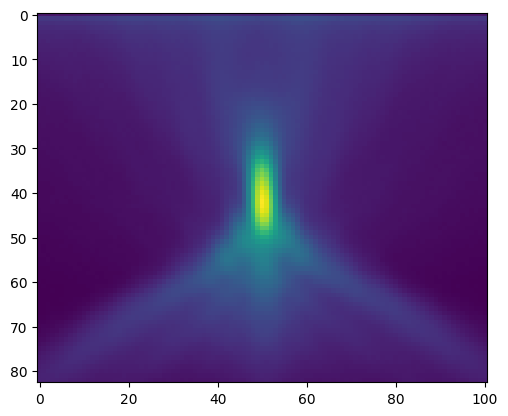

In [105]:
pix_mic_conv = 0.02
a = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")
a = a[np.argwhere(a.sum(axis=(1,2)))][:,0,:,:].astype(int)
a = center_data(a)
#a -= int(np.percentile(a,10))
#a = np.clip(a, 0, np.inf).astype(int)
#a = np.array([gaussian(x, 1) for x in a])
a = a/a.max()
a = img_as_uint(a)
a = a[10:-11,70:-70,70:-70]
#a = x_rotated
plt.imshow(a.sum(axis=1))

(83, 101, 101)

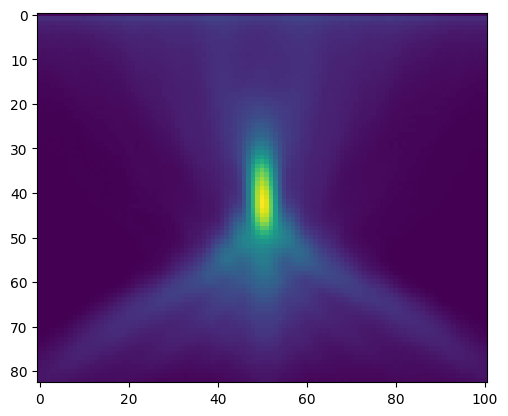

In [223]:
target_psf = a
#target_psf = target_psf/target_psf.max()
#target_psf = (target_psf*2**16).astype(int)
target_psf = prep_data_for_PR(target_psf, multiplier = 1)
plt.imshow(target_psf.sum(axis=1))
target_psf.shape

(<Figure size 800x800 with 8 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7a8ba437bd60>)

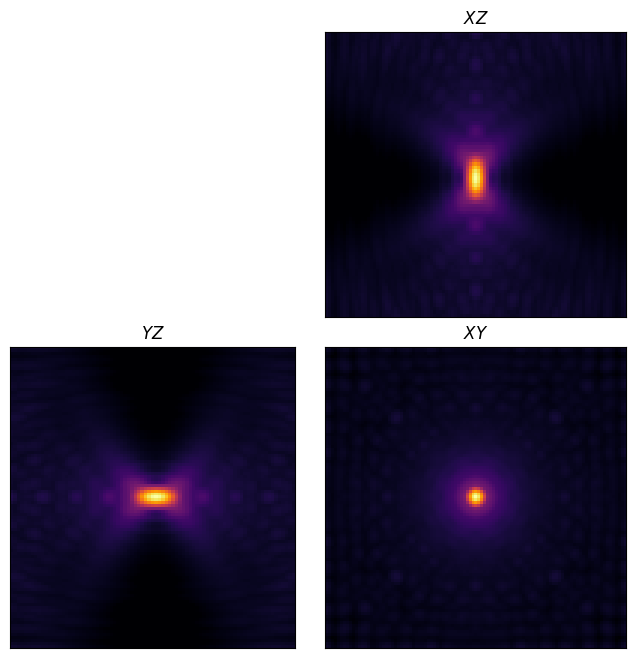

In [224]:
params = dict(wl=515.9, na=1.45, ni=1.518, res=43.33, zres=50, vec_corr = "total", condition = "sine")
HanserPSF(**params, size=a.shape[1], zsize=a.shape[0]).plot_psf()

In [225]:
PR_result = retrieve_phase(target_psf, params, max_iters=500, phase_only = False)

In [226]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


In [252]:
import numpy as np

def make3DGaussian(size, fwhm=(3, 3, 3), center=None):
    """ Make a cubic gaussian kernel with variable fwhm along each axis.

    size is the length of a side of the cube
    fwhm is a tuple of full-width-half-maximum for each axis (fwhm_x, fwhm_y, fwhm_z), 
    which can be thought of as an effective radius for each axis.
    """

    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis, np.newaxis]
    z = x[:, np.newaxis, np.newaxis, np.newaxis]

    if center is None:
        x0 = y0 = z0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
        z0 = center[2]

    fwhm_x, fwhm_y, fwhm_z = fwhm

    return np.exp(-4*np.log(2) * ((x-x0)**2 / fwhm_x**2 + (y-y0)**2 / fwhm_y**2 + (z-z0)**2 / fwhm_z**2))


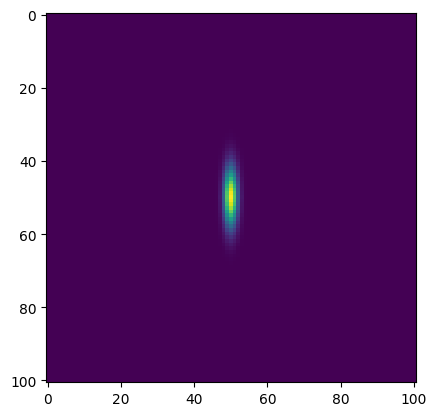

In [262]:
plt.imshow(make3DGaussian(101, (13,3,13)).reshape(101,101,101).sum(axis=2))

In [228]:
from copy import deepcopy
oldphase = deepcopy(PR_result.phase)
oldmag = deepcopy(PR_result.mag)

In [229]:
#PR_result.phase = oldphase * makeGaussian(PR_result.phase.shape[0], 15)
#PR_result.mag = oldmag * makeGaussian(PR_result.mag.shape[0], 15)

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'Magnitude Coefficients'}>,
        <Axes: title={'center': 'Phase Coefficients'}, xlabel="Noll's Number">],
       dtype=object))

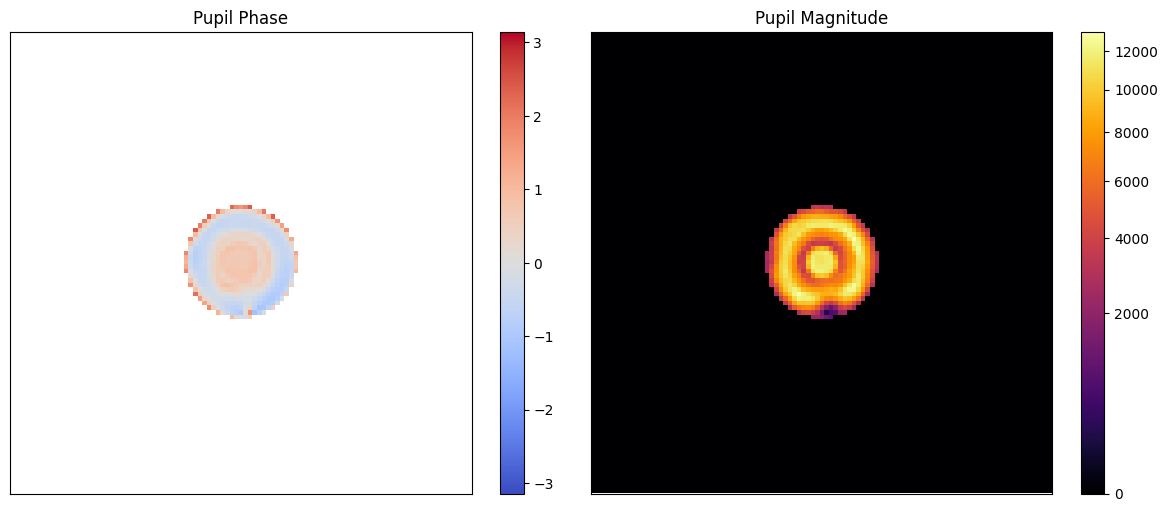

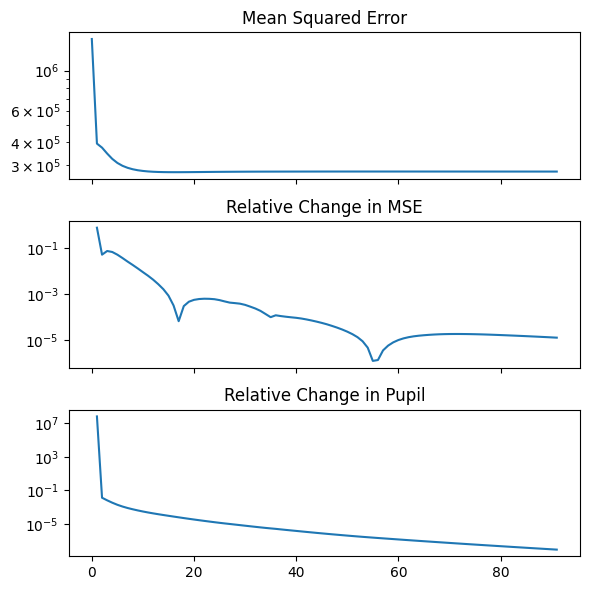

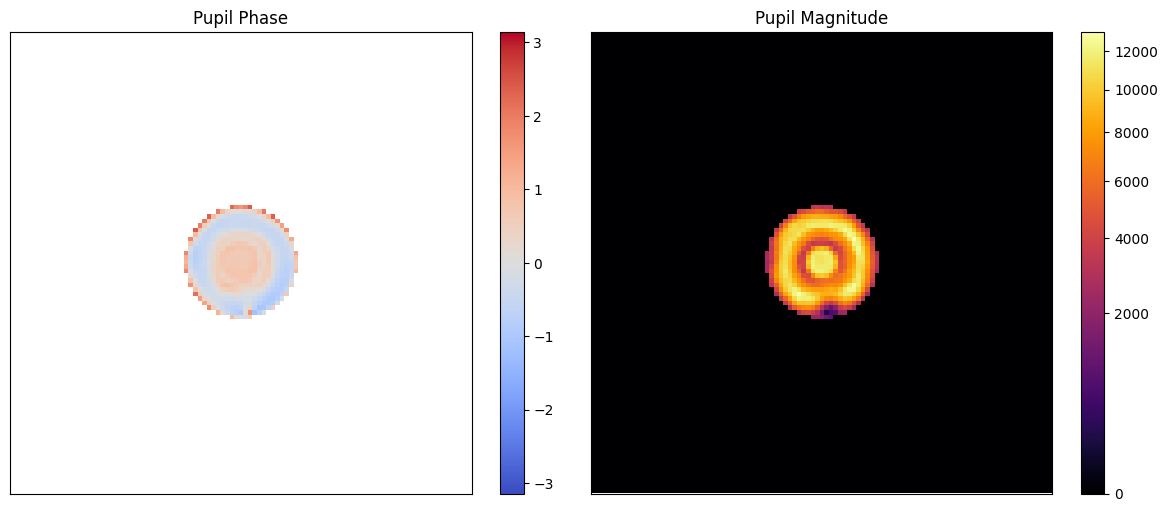

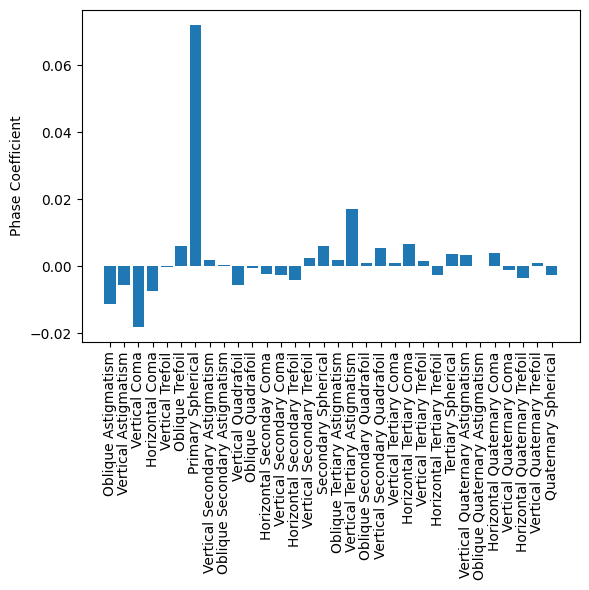

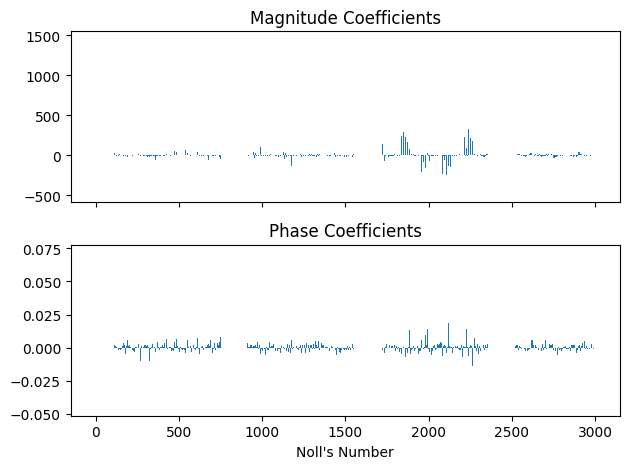

In [294]:
PR_result.fit_to_zernikes(3000)
PR_result.plot()
PR_result.plot_convergence()
PR_result.zd_result.plot()
PR_result.zd_result.plot_named_coefs()
PR_result.zd_result.plot_coefs()

In [295]:
from numpy.fft import fftn, fftshift, ifftn, ifftshift
def easy_fft(data, axes=None):
    """FFT that includes shifting."""
    return fftshift(fftn(ifftshift(data, axes=axes), axes=axes), axes=axes)

In [296]:
old_result = deepcopy(PR_result)

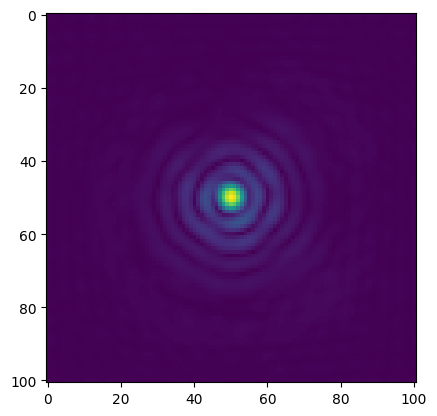

In [297]:
result_psf = PR_result.model
result_psf = apply_aberration(result_psf, PR_result.zd_result.mcoefs, PR_result.zd_result.pcoefs)
result_psf = result_psf.PSFi
plt.imshow(result_psf[result_psf.shape[0]//2]**(1/2))

In [298]:
result_psf.shape

(83, 101, 101)

In [299]:
101-83

18

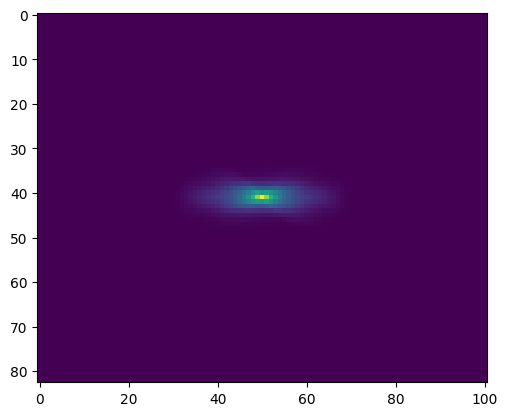

In [307]:
result_otf = easy_fft(result_psf)
rescaled_otf = result_otf * make3DGaussian(result_otf.shape[1], (30,30,11)).reshape(result_otf.shape[1],result_otf.shape[1],result_otf.shape[1])[9:-9]

plt.imshow(np.real(rescaled_otf).sum(axis=2))

In [308]:
rescaled_psf = np.real(easy_fft(rescaled_otf))
rescaled_psf = rescaled_psf[::-1,:,:]
rescaled_psf = rescaled_psf[:,::-1,:]
rescaled_psf = rescaled_psf[:,:,::-1]

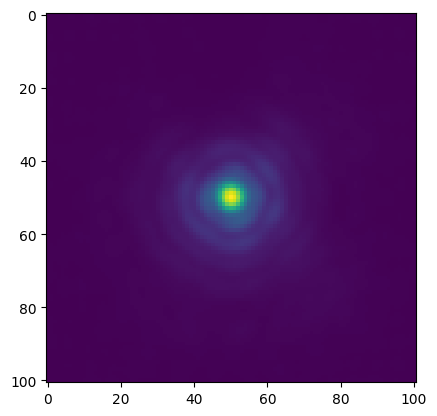

In [309]:
plt.imshow(rescaled_psf[rescaled_psf.shape[0]//2]**(1/2))

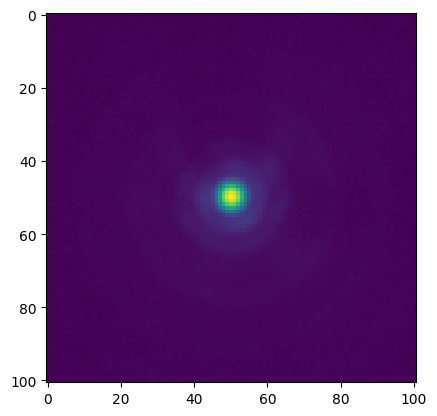

In [310]:
plt.imshow(a[a.shape[0]//2]**(1/2))

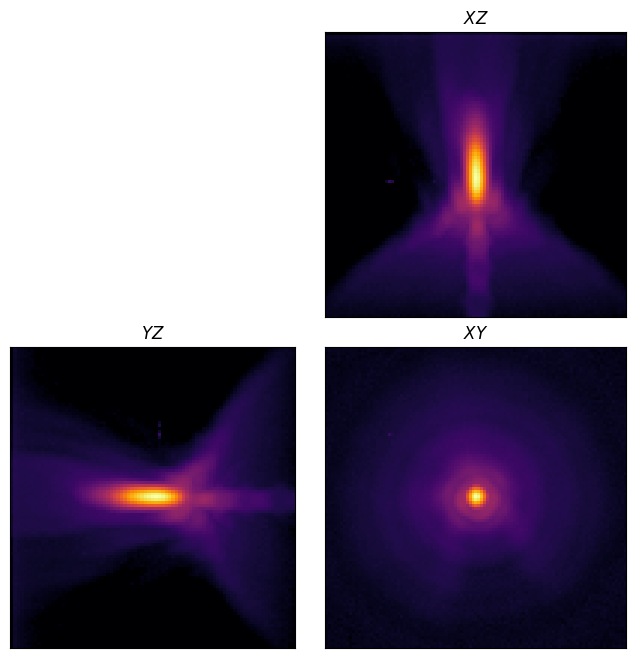

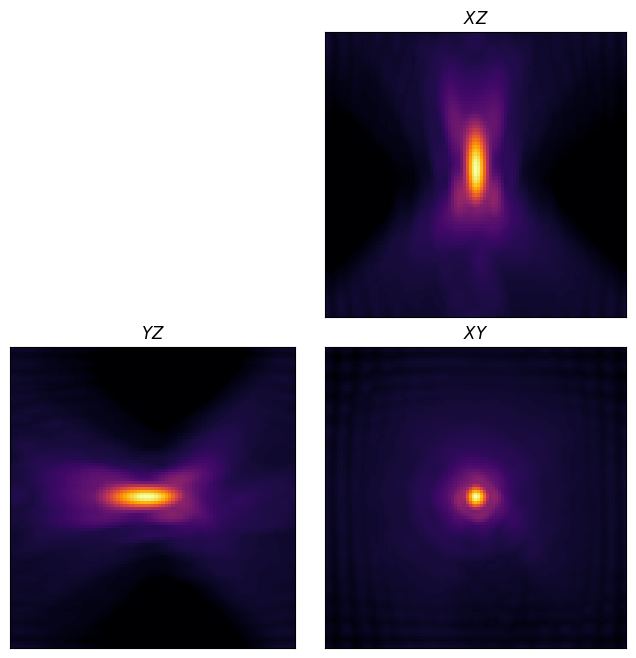

In [319]:
# Simulate HanserPSF with parameters


# this part is very kludgy
PR_result.model.PSFi = target_psf
PR_result.model.plot_psf()
plt.savefig("iPSF_for_retrieval.svg")
PR_result.model.PSFi = rescaled_psf
PR_result.model.plot_psf()
plt.savefig("phase_retrieved_PSF.svg")

target_psf = target_psf / target_psf.max()
result_psf = result_psf / result_psf.max()


In [312]:
from skimage.transform import rotate
def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline/midline.max()

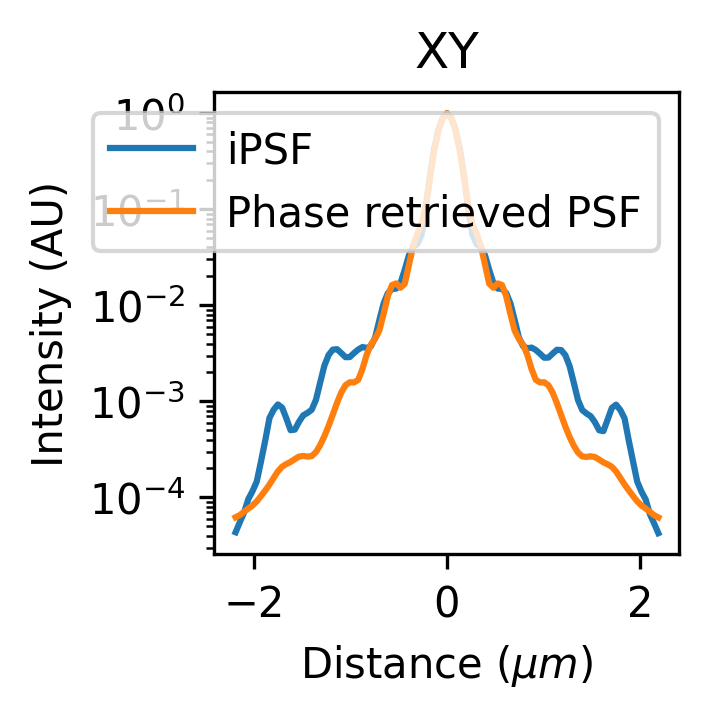

In [392]:
plt.figure(figsize=(2,2),dpi=300)
x = np.linspace(-target_psf.shape[1]*0.065/1.5/2,target_psf.shape[1]*0.065/1.5/2, target_psf.shape[1])
plt.plot(x, get_midline_rotate_method(target_psf[41]), label = "iPSF")
plt.plot(x, get_midline_rotate_method(rescaled_psf[41]), label = "Phase retrieved PSF")
plt.yscale("log")
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.title("XY")
plt.legend()
plt.savefig("SI_phase_retrieved_profile_comparison.svg")

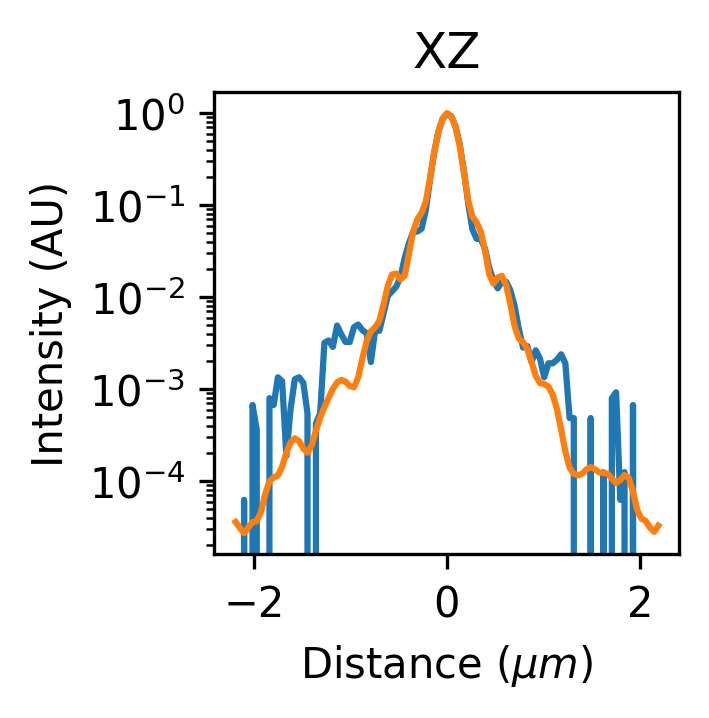

In [394]:
plt.figure(figsize=(2,2),dpi=300)
x = np.linspace(-target_psf.shape[1]*0.065/1.5/2,target_psf.shape[1]*0.065/1.5/2, target_psf.shape[1])
plt.plot(x,target_psf[:,target_psf.shape[1]//2][target_psf[:,target_psf.shape[1]//2].shape[0]//2], label = "iPSF")
plt.plot(x,(rescaled_psf[:,rescaled_psf.shape[1]//2][target_psf[:,rescaled_psf.shape[1]//2].shape[0]//2])/(rescaled_psf[:,rescaled_psf.shape[1]//2][target_psf[:,rescaled_psf.shape[1]//2].shape[0]//2].max()), label = "Phase retried PSF")
plt.title("XZ")
plt.xlabel("Distance ($\mu m$)")
plt.yscale("log")
plt.ylabel("Intensity (AU)")
plt.savefig("SI_phase_retrieved_profile_comparison_xz.svg")

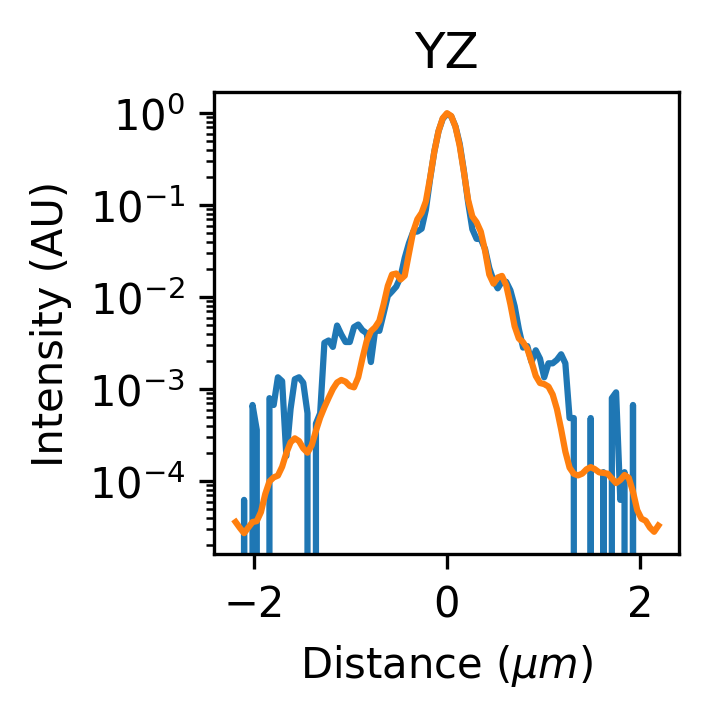

In [395]:
plt.figure(figsize=(2,2),dpi=300)
plt.title("YZ")
x = np.linspace(-target_psf.shape[1]*0.065/1.5/2,target_psf.shape[1]*0.065/1.5/2, target_psf.shape[1])
plt.plot(x,target_psf[:,target_psf.shape[1]//2][target_psf[:,target_psf.shape[1]//2].shape[0]//2])
plt.plot(x,(rescaled_psf[:,rescaled_psf.shape[1]//2][target_psf[:,rescaled_psf.shape[1]//2].shape[0]//2])/(rescaled_psf[:,rescaled_psf.shape[1]//2][target_psf[:,rescaled_psf.shape[1]//2].shape[0]//2].max()))
plt.yscale("log")
plt.ylabel("Intensity (AU)")
plt.xlabel("Distance ($\mu m$)")
plt.savefig("SI_phase_retrieved_profile_comparison_yz.svg")

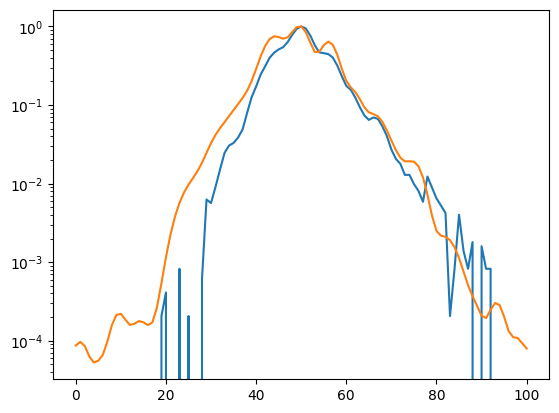

In [366]:
plt.plot(target_psf[:,:,target_psf.shape[2]//2][target_psf[:,:,target_psf.shape[2]//2].shape[1]//2]/(target_psf[:,:,target_psf.shape[2]//2][target_psf[:,:,target_psf.shape[2]//2].shape[1]//2].max()))
plt.plot((rescaled_psf[:,:,rescaled_psf.shape[2]//2][rescaled_psf[:,:,rescaled_psf.shape[2]//2].shape[1]//2])/(rescaled_psf[:,:,rescaled_psf.shape[2]//2][rescaled_psf[:,:,rescaled_psf.shape[2]//2].shape[1]//2].max()))

plt.yscale("log")

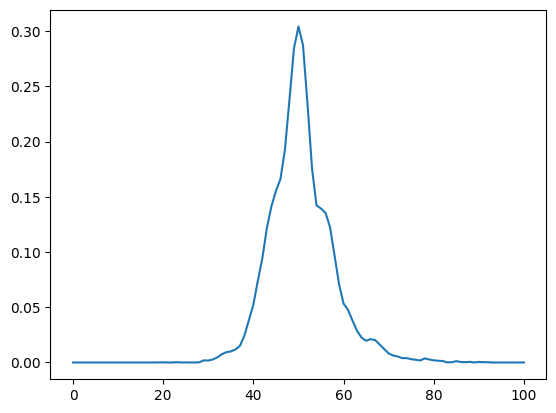

In [358]:
plt.plot(target_psf[:,:,target_psf.shape[2]//2][target_psf[:,target_psf.shape[2]//2].shape[1]//2])